# Word2vec
可參考 
* http://nbviewer.jupyter.org/url/b81.org/s/math_intro11.ipynb

In [1]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import numpy as np


In [2]:
# 設定環境變數來控制 keras, theano
import os
os.environ['KERAS_BACKEND']="tensorflow"
os.environ['THEANO_FLAGS']="floatX=float32, device=cuda"

### 用 jieba 斷詞

In [3]:
import jieba
jieba.set_dictionary('dict.txt.big')
" - ".join(jieba.cut("今天天氣很好"))

Building prefix dict from /home/tjw/src/HackNTU_Data_2017/Week08/dict.txt.big ...
Loading model from cache /tmp/jieba.uabe345d172aa2c353a2c9ed1c2ff896a.cache
Loading model cost 0.986 seconds.
Prefix dict has been built succesfully.


'今天天氣 - 很 - 好'

## 下載資料

In [4]:
if not os.path.isfile("sdyxz_all.txt"):    
    with open("sdyxz_all.txt","w") as outf:
        for i in range(1, 41):
            r = urlopen('http://www.millionbook.net/wx/j/jingyong/sdyxz/%03d.htm'%i)
            html = r.read().decode('cp950', "ignore")
            bs = BeautifulSoup(html, 'lxml')
            text = bs.findAll('td')[6].get_text()
            if len(text)<100:
                print("error")
                break
            print (i, len(text))
            outf.write(text)

In [5]:
# 忽略不要的詞
ignore_words = set("""the
of
is
and
to
in
that
we
for
an
are
by
be
as
on
with
can
if
from
which
you
it
this
then
at
have
all
not
one
has
or
that
的
了
和
是
就
都
而
及
與
著
或
一個
沒有
你
我
他
她
我們
你們
妳們
他們
她們
是否""".split("\n"))|set("，。*「」：？\n\u3000！、…』『《》-")

# 自訂辭典
jieba.add_word("黃蓉")
jieba.suggest_freq("黃蓉", True)
jieba.add_word("郭靖")
jieba.suggest_freq("郭靖", True)
with open("sdyxz_all.txt", "r") as f:
    words = [w for w in jieba.cut(f.read()) if w not in ignore_words]
print("len=", len(words))
print(words[:100])

len= 384051
['第一回', '風雪', '驚變', '錢塘江', '浩浩', '江水', '日日夜夜', '無窮', '無休', '從', '臨安', '牛家村', '邊', '繞過', '東流', '入海', '江畔', '一排', '數十株', '烏', '柏樹', '葉子', '似', '火燒', '般紅', '正是', '八月', '天時', '村前村後', '野草', '剛', '起始', '變黃', '一抹', '斜陽', '映照', '之下', '更增', '幾分', '蕭索', '兩株', '大', '松樹', '下圍', '一堆', '村民', '男男女女', '十幾個', '小孩', '正自', '聚精會神', '聽', '瘦削', '老者', '說話', '那', '說話', '人五', '十來', '歲', '年紀', '一件', '青布', '長袍', '早洗', '得', '褪成', '藍灰色', '只', '聽', '兩片', '梨花', '木板', '碰', '幾下', '左手', '中', '竹棒', '在', '一面', '小', '羯鼓', '上', '敲起', '得', '得', '連聲', '唱道', '小桃', '無主自', '開花', '煙草', '茫茫', '帶', '晚鴉', '幾處', '敗垣圍', '故井', '向來', '一一']


### 先處理掉少用字

In [6]:
# 總共有多少種字？
len(set(words))

47134

我們只考慮最常用的 10000 字， 其他字用 UNK 取代

In [7]:
import collections
# 先統計字數
counter = collections.Counter(words)
# 可以看一下 counter 是的內容

In [8]:
def sep_words(words):
    for w in words:
        if counter[w]<3:
            for c in w:
                yield c
        else:
            yield w
words = list(sep_words(words))
len(words)

434741

In [9]:
counter = collections.Counter(words)


In [10]:
# 最常見的 30 個字
counter.most_common(30)

[('道', 7119),
 ('在', 5042),
 ('郭靖', 3364),
 ('也', 3086),
 ('不', 3050),
 ('得', 2640),
 ('又', 2622),
 ('這', 2561),
 ('那', 2524),
 ('黃蓉', 2493),
 ('去', 2225),
 ('上', 2098),
 ('一', 2001),
 ('人', 1916),
 ('中', 1867),
 ('說', 1857),
 ('卻', 1777),
 ('有', 1728),
 ('來', 1697),
 ('已', 1682),
 ('到', 1678),
 ('見', 1559),
 ('聽', 1548),
 ('但', 1504),
 ('要', 1452),
 ('叫', 1320),
 ('向', 1300),
 ('大', 1234),
 ('之', 1225),
 ('好', 1187)]

In [11]:
words

['第',
 '一',
 '回',
 '風雪',
 '驚',
 '變',
 '錢塘江',
 '浩',
 '浩',
 '江水',
 '日日夜夜',
 '無窮',
 '無',
 '休',
 '從',
 '臨安',
 '牛家村',
 '邊',
 '繞過',
 '東',
 '流',
 '入海',
 '江',
 '畔',
 '一排',
 '數',
 '十',
 '株',
 '烏',
 '柏樹',
 '葉',
 '子',
 '似',
 '火燒',
 '般',
 '紅',
 '正是',
 '八月',
 '天時',
 '村',
 '前',
 '村',
 '後',
 '野',
 '草',
 '剛',
 '起始',
 '變',
 '黃',
 '一抹',
 '斜',
 '陽',
 '映照',
 '之下',
 '更增',
 '幾分',
 '蕭',
 '索',
 '兩株',
 '大',
 '松樹',
 '下',
 '圍',
 '一堆',
 '村民',
 '男',
 '男',
 '女',
 '女',
 '十幾個',
 '小孩',
 '正自',
 '聚精會神',
 '聽',
 '瘦削',
 '老者',
 '說話',
 '那',
 '說話',
 '人',
 '五',
 '十來',
 '歲',
 '年紀',
 '一件',
 '青布',
 '長袍',
 '早',
 '洗',
 '得',
 '褪',
 '成',
 '藍',
 '灰',
 '色',
 '只',
 '聽',
 '兩',
 '片',
 '梨',
 '花',
 '木板',
 '碰',
 '幾下',
 '左手',
 '中',
 '竹棒',
 '在',
 '一面',
 '小',
 '羯',
 '鼓',
 '上',
 '敲',
 '起',
 '得',
 '得',
 '連聲',
 '唱道',
 '小',
 '桃',
 '無',
 '主',
 '自',
 '開',
 '花',
 '煙',
 '草',
 '茫茫',
 '帶',
 '晚',
 '鴉',
 '幾',
 '處',
 '敗',
 '垣',
 '圍',
 '故',
 '井',
 '向來',
 '一一',
 '人家',
 '那',
 '說話',
 '人',
 '將',
 '木板',
 '敲',
 '幾下',
 '說道',
 '這首',
 '七',
 '言',
 '詩',
 '說',
 '兵',
 '火

In [12]:
from gensim.models import word2vec
import logging

In [23]:
sentences = [words[i:i+1000] for i in range(0, len(words), 1000)]

In [53]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
model = word2vec.Word2Vec(sentences, sg=1, size=100, min_count=1, window=8, iter=25, negative=5)

2017-05-09 16:43:43,265 : INFO : collecting all words and their counts
2017-05-09 16:43:43,265 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-05-09 16:43:43,336 : INFO : collected 18172 word types from a corpus of 434741 raw words and 435 sentences
2017-05-09 16:43:43,337 : INFO : Loading a fresh vocabulary
2017-05-09 16:43:43,423 : INFO : min_count=1 retains 18172 unique words (100% of original 18172, drops 0)
2017-05-09 16:43:43,424 : INFO : min_count=1 leaves 434741 word corpus (100% of original 434741, drops 0)
2017-05-09 16:43:43,480 : INFO : deleting the raw counts dictionary of 18172 items
2017-05-09 16:43:43,481 : INFO : sample=0.001 downsamples 31 most-common words
2017-05-09 16:43:43,482 : INFO : downsampling leaves estimated 409275 word corpus (94.1% of prior 434741)
2017-05-09 16:43:43,482 : INFO : estimated required memory for 18172 words and 100 dimensions: 23623600 bytes
2017-05-09 16:43:43,553 : INFO : resetting layer weights
2017-05-09 

In [55]:
model.wv.most_similar('吃')

[('一驚', 0.7296633720397949),
 ('糲', 0.687698245048523),
 ('五珍', 0.6864144802093506),
 ('蘑', 0.677970826625824),
 ('煨', 0.6770339012145996),
 ('麵', 0.6668568253517151),
 ('膾', 0.6651573777198792),
 ('苦頭', 0.6593719720840454),
 ('殘菜', 0.6576591730117798),
 ('好吃', 0.6303290724754333)]

In [56]:
model.wv.most_similar(positive=['西毒','洪七公'], negative=['北丐'])

[('黃蓉', 0.5206567049026489),
 ('歐陽鋒', 0.49580344557762146),
 ('郭靖', 0.4456004202365875),
 ('沉肩', 0.43416541814804077),
 ('陰沉', 0.42809873819351196),
 ('果真如此', 0.4270661175251007),
 ('一線', 0.41873422265052795),
 ('叫化', 0.4184786379337311),
 ('黃蓉忙', 0.4172767996788025),
 ('七公', 0.4136349558830261)]

In [66]:
model.wv.most_similar_cosmul(positive=['郭靖','穆念慈'], negative = ['楊康'] ) 

[('黃蓉', 0.9208547472953796),
 ('靖哥哥', 0.9063557386398315),
 ('柔聲道', 0.8894891738891602),
 ('廝守', 0.8872582316398621),
 ('永遠', 0.8833402991294861),
 ('蹙眉', 0.879569947719574),
 ('手道', 0.8783940076828003),
 ('礙事', 0.8731006383895874),
 ('拿藥', 0.8672891855239868),
 ('永不', 0.8671412467956543)]

In [65]:
model.wv.most_similar_cosmul(positive=['洪七公', '蛤蟆功'], negative=['歐陽鋒']) 

[('一陽指', 0.8603169322013855),
 ('降龍十八掌', 0.8508104085922241),
 ('空明拳', 0.8481013178825378),
 ('快又準', 0.8092823624610901),
 ('破去', 0.8084005117416382),
 ('第二招', 0.8070525527000427),
 ('青龍', 0.8029625415802002),
 ('算是', 0.8017399311065674),
 ('位居', 0.7996737360954285),
 ('不愧', 0.7967389225959778)]

In [62]:
model.wv.most_similar(positive=['吃', "酒"], negative=["飯"])

[('喝', 0.6327210664749146),
 ('七碗', 0.5234313011169434),
 ('一大口', 0.5065366625785828),
 ('半碗', 0.49932488799095154),
 ('唱著', 0.4989270865917206),
 ('程二女', 0.4868518114089966),
 ('妙哉', 0.4837992191314697),
 ('蘑', 0.4831634759902954),
 ('煨', 0.48288285732269287),
 ('蠶豆', 0.4808100461959839)]

In [71]:
samples = 500
labels = [w[0] for w in counter.most_common(samples)]
vec = np.array([model[w] for w in labels])

In [73]:
# 用 t-sne 降低維度
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
low_dim_embs = tsne.fit_transform(vec)

In [74]:
# 從 00Download.ipynb 來的
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import os.path
from urllib.request import urlopen
def download_req(req, filename):
    total = int(req.getheader("Content-Length"))
    with open(filename,'wb') as f:
        i = 0
        for data in iter(lambda: req.read(8192), b""):  
            i+=1
            f.write(data)
            print("\rdownloading: %5.1f%%"%(i*8192*100.0/total), end="")

# 字體下載
font_filename = 'NotoSansCJKtc-hinted.zip'
font_url = "https://noto-website-2.storage.googleapis.com/pkgs/"+font_filename
# 改變這行才能真正下載
if not (os.path.isfile(font_filename) and os.path.getsize(font_filename)==121247052):
    with urlopen(font_url) as req:
        download_req(req, "NotoSansCJKtc-hinted.zip")
# Extract Font files
import zipfile
with zipfile.ZipFile(font_filename) as zf:
    for f in zf.namelist():
        if f.endswith('.otf'):
            print("extract", f)
            zf.extract(f)

fp = matplotlib.font_manager.FontProperties(fname = 'NotoSansCJKtc-Regular.otf')
matplotlib.font_manager.fontManager.ttffiles.append(fp.get_file())
font_entry = matplotlib.font_manager.FontEntry(fp.get_file(), name=fp.get_name(),
                                               style=fp.get_style(), variant=fp.get_variant(),
                                              weight=fp.get_weight(), stretch=fp.get_stretch(), size=fp.get_size())

matplotlib.font_manager.fontManager.ttflist.append(font_entry)
plt.rcParams['font.family'] = fp.get_name()

extract NotoSansCJKtc-Black.otf
extract NotoSansCJKtc-Bold.otf
extract NotoSansCJKtc-DemiLight.otf
extract NotoSansCJKtc-Light.otf
extract NotoSansCJKtc-Medium.otf
extract NotoSansCJKtc-Regular.otf
extract NotoSansCJKtc-Thin.otf
extract NotoSansMonoCJKtc-Bold.otf
extract NotoSansMonoCJKtc-Regular.otf


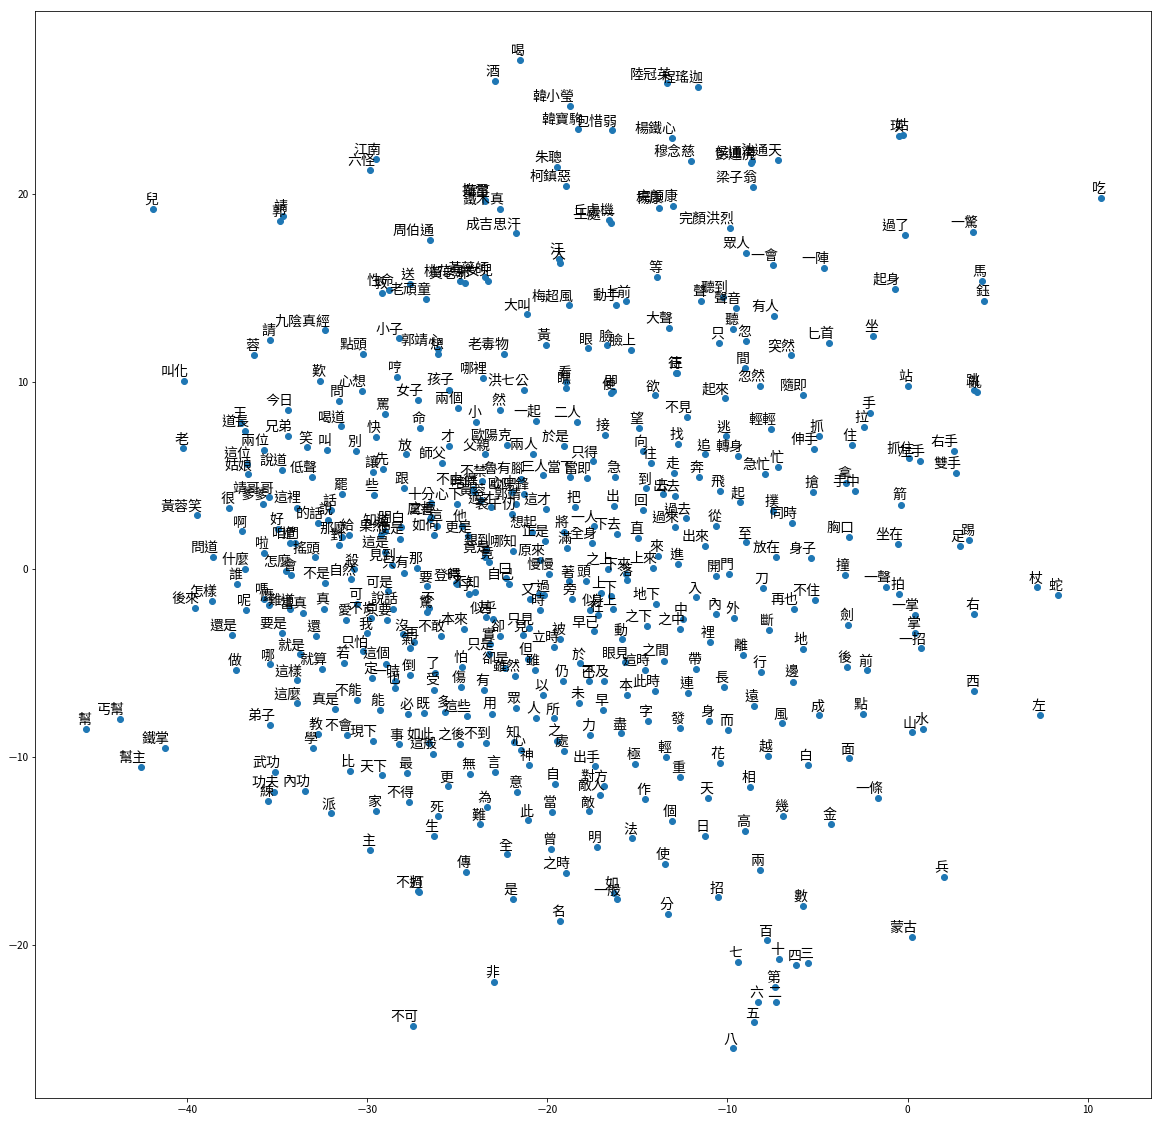

In [75]:
# 畫出來

plt.figure(figsize=(20,20))
plt.scatter(low_dim_embs[:, 0], low_dim_embs[:, 1])
for i, label in enumerate(labels):
    x, y = low_dim_embs[i]
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 fontsize=14,
                 ha='right',
                 va='bottom')